$\texttt{NBA-DATAMINING.csv}$ contains stats for NBA games from 2011 to 2018.  The goal is to predict the winner of any game with better than 50% accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
data = pd.read_csv('NBA_DATAMINING.csv')
data.head()

,date,team,points,assists,biggest lead,blocks,defensive rebounds,fast break points,field goals attempted,field goals made,...,o:site,o:site streak,o:steals,o:streak,o:team rebounds,o:three pointers attempted,o:three pointers made,o:turnovers,o:wins,season
0,20091115,Lakers,91,23,14,10,32,18,84,32,...,away,-1,9,-1,8,32,9,19,5,2009
1,20091115,Pistons,90,12,7,6,32,6,83,38,...,away,-2,11,1,7,16,7,7,6,2009
2,20091115,Suns,101,18,7,4,34,10,78,35,...,away,-1,6,2,5,24,9,11,5,2009
3,20091115,Thunder,93,13,3,1,30,10,85,33,...,away,4,9,-3,9,17,5,12,3,2009
4,20091116,Bucks,113,26,2,4,33,18,99,44,...,away,-3,5,2,7,20,10,15,7,2009


Each row has the results of each game.  In order to preict games faithfully we can't steal from the future,
i.e. we can't use the results of the game to predict the outcome.

In [3]:
#lets just start with a few predictors
predictors = ['wins','o:wins',
              'win_ratio','o:win_ratio',
              'points','o:points',
              'points last 10','o:points last 10',
              'assists','o:assists',
              'turnovers','o:turnovers',
              'streak','o:streak',
              'offensive rebounds','o:offensive rebounds']

In [4]:
def make_target(data):
    """
    Determine which team won; return 1 for home team, 0 for opponent 
    """
        
    if data['points'] > data['o:points']:
        return 1
    else:
        return 0

In [5]:
#  build feature columns

#  make target
data['won'] = data.apply(make_target, axis=1)

#  win ratios for home and opponent
data['win_ratio'] = data['wins'] / data['game number']
data['o:win_ratio'] = data['o:wins'] / data['game number']

#  sum of points in previous 10 games
data['points last 10'] = data['points'].rolling(10).sum()
data['o:points last 10'] = data['o:points'].rolling(10).sum()

In [6]:
# I'll put stats for each season/team/predictor in a dictionary: 
team_season_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

In [7]:
def get_predictors_for_team(season, team, predictorname):
    """
    Grab the predictor from the stats dictionary
    
    int season - year during which the season took place, e.g. 2011
    str team - team name, e.g. 'Bulls'
    str predictorname - predictor to return for given team & season, e.g. 'points'
    """
    
    predictor = team_season_stats[season][team][predictorname]
    
    #  see if predictor has many entries
    try: len(predictor)
    except: return predictor
    
    #  if it has one entry, return it
    if len(predictor) == 0:
        return 
    
    #  if it has many, return the most recent one
    else:
        return predictor[-1]


In [8]:

def elo(R1, R2, S):
    """
    Calculate the Elo score for competing teams given the outcome
    
    float R1 - previous Elo score of team 1
    float R2 - previous Elo score of team 2
    int S - result of the matchup; 1 for home win, 0 for opponent win
    """
    
    #set k factor:
    k = 20.;
    
    #transformed ratings:
    r1 = np.power(10, (R1/400.))
    r2 = np.power(10, (R2/400.))
    
    #expected scores:
    e1 = r1 / (r1 + r2)
    e2 = r2 / (r1 + r2)
    
    #set s1, s2 based on outcome:
    s1 = int(S==1)
    s2 = int(S!=1)
    
    #updated elo ratings
    new_R1 = R1 + k * (s1 - e1)
    new_R2 = R2 + k * (s2 - e2)

    
    return new_R1, new_R2

In [9]:
#  just for fun I want to see how elo changes over each season
elo_over_time = defaultdict(lambda: defaultdict(list))

In [ ]:
def build_data(all_data):
    
    return X, y, season

In [10]:
def build_data(all_data):
    # X and y WILL CONTAIN OUR DATAxPREDICTORS and TARGETS RESPECTIVELY
    # X and y will eventually be fed into scikit learn 
    
    # X is 2D (datasamples x predictors)
    # y are the 1D target values (0 or 1 for win or loss, TARGETS)
    
    # return X, y, season - "season" correspond to the season in which each data sample falls. 
    # season should have the exact same dimensions as y
    
    X = []
    y = []
    season = []

    #initialize stats dictionary? I guess?
    for s in np.unique(data['season']): 
        team_season_stats[s] = {} 
        for team in np.unique(data['team']): 
            team_season_stats[s][team] = {} 
            for predictor in predictors:
                team_season_stats[s][team][predictor] = [] 
            team_season_stats[s][team]['elo'] = 1000

    
    for index, row in all_data.iterrows(): 
        
        #split predictors for home and away teams
        home_predictors = [i for i in predictors if i[:2] != 'o:' and i != 'elo']
        away_predictors = [i for i in predictors if i[:2] == 'o:' and i != 'o:elo']
        
        #get predictors for each matchup.  predictors come from stats dictionary,
        # which is updated AFTER each row is added to X, so there is no stolen 'future' data
        new_team_data = [get_predictors_for_team(row['season'], row['team'], i) for i in home_predictors]
        new_oteam_data = [get_predictors_for_team(row['season'], row['o:team'], i) for i in home_predictors]
        new_team_data.append(team_season_stats[row['season']][row['team']]['elo'])
        new_oteam_data.append(team_season_stats[row['season']][row['o:team']]['elo'])
        
        # some of the rows will not contain predictors.  don't use these
        if (None not in new_team_data) and (None not in new_oteam_data): 
            X.append(new_team_data + new_oteam_data)
            y.append(row['won'])
            season.append(row['season'])
        
        #stats to be updated for home/away teams
        home_stats = {}
        for predictor in home_predictors:
            home_stats[predictor] = row[predictor]

        away_stats = {}
        for predictor in away_predictors:
            away_stats[predictor[2:]] = row[predictor]

        #update stats for each team.  
        #'o:team's stats count under its 'predictor' columns rather than under 'o:predictor'
        for predictor in home_predictors:
            team_season_stats[row['season']][row['team']][predictor].append(home_stats[predictor])
        for predictor in home_predictors:
            team_season_stats[row['season']][row['o:team']][predictor].append(home_stats[predictor])
            
        #update Elo scores
        home_elo = team_season_stats[row['season']][row['team']]['elo']
        away_elo = team_season_stats[row['season']][row['o:team']]['elo']
        
        new_elos = elo(home_elo, away_elo, row['won'])
        
        team_season_stats[row['season']][row['team']]['elo'] = new_elos[0]
        team_season_stats[row['season']][row['o:team']]['elo'] = new_elos[1]
        
        #just for fun: update elo over time
        elo_over_time[row['season']][row['team']].append(home_elo)
        elo_over_time[row['season']][row['o:team']].append(away_elo)
        
    X = np.vstack(X)
    return X, y, season


In [11]:
import time
t1 = time.time()
X, y, season = build_data(data)
t2 = time.time()
print('time to build data:', t2-t1)

time to build data: 14.088202953338623


(11033, 18)
11033
11033


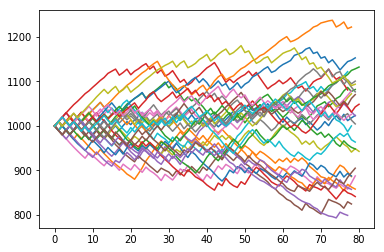

In [26]:
print(X.shape)
print(len(y))
print(len(season))
for t in team_season_stats[2017].keys():
    plt.plot(elo_over_time[2017][t], label=t)
# plt.legend()
# plt.savefig('elos_over_2016.pdf')
plt.show()

 ** Fitting **
 
 now that we have filled our data, features and targets, we can feed this in to scikit learn logistic regression.

In [27]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# This is scikit learn log regression model. 
# We just need to feed it data and train!
model = linear_model.LogisticRegression() 
# random_forest = RandomForestClassifier(n_estimators=100)

season = np.array(season,dtype='int')

# splitting up train and test data
train = np.array(season) != 2017
test = np.array(season) == 2017

model.fit(np.array(X)[train], np.array(y)[train]) #This is the training.
# random_forest.fit(np.array(X)[train], np.array(y)[train])

print('Model done fitting!')
print('Logistic Regression Training Accuracy %.3f'%(model.score(np.array(X)[train,:],np.array(y)[train])))
# print('Random Forest Training Accuracy %.3f'%(random_forest.score(np.array(X)[train,:],np.array(y)[train])))
# print(random_forest.feature_importances_)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print ('2017 Season Test Accuracy (Logistic Regression) %.3f'%(model.score(np.array(X)[test,:],np.array(y)[test])))
# print ('2017 Season Test Accuracy (Random Forest) %.3f'%(random_forest.score(np.array(X)[test,:],np.array(y)[test])))

In [28]:
season

array([2009, 2009, 2009, ..., 2017, 2017, 2017])

In [39]:
data

,date,team,points,assists,biggest lead,blocks,defensive rebounds,fast break points,field goals attempted,field goals made,...,o:three pointers attempted,o:three pointers made,o:turnovers,o:wins,season,won,win_ratio,o:win_ratio,points last 10,o:points last 10
0,20091115,Lakers,91,23,14,10,32,18,84,32,...,32,9,19,5,2009,0,0.700000,0.500000,NaN,NaN
1,20091115,Pistons,90,12,7,6,32,6,83,38,...,16,7,7,6,2009,0,0.500000,0.600000,NaN,NaN
2,20091115,Suns,101,18,7,4,34,10,78,35,...,24,9,11,5,2009,1,0.727273,0.454545,NaN,NaN
3,20091115,Thunder,93,13,3,1,30,10,85,33,...,17,5,12,3,2009,0,0.500000,0.300000,NaN,NaN
4,20091116,Bucks,113,26,2,4,33,18,99,44,...,20,10,15,7,2009,0,0.625000,0.875000,NaN,NaN
5,20091116,Hawks,99,20,8,5,32,19,91,39,...,17,7,17,8,2009,1,0.727273,0.727273,NaN,NaN
6,20091116,Magic,97,19,12,2,28,14,77,33,...,14,4,16,3,2009,1,0.636364,0.272727,NaN,NaN
7,20091117,Cavaliers,114,24,15,7,28,11,79,46,...,24,9,14,3,2009,1,0.636364,0.272727,NaN,NaN
8,20091117,Heat,87,17,5,4,27,8,72,31,...,14,5,11,5,2009,0,0.700000,0.500000,NaN,NaN
9,20091117,Pelicans,110,23,17,2,32,11,81,37,...,20,7,17,4,2009,1,0.250000,0.333333,995.0,1008.0
